In [1]:
from fastai.script import *

from fastai.vision import *

from fastai.callbacks import *

from fastai.distributed import *

from fastai.callbacks.tracker import *

from torchvision.models import vgg16
import os 


数据集收集

In [2]:
path = Path('../data/train/')
path.ls()

[PosixPath('data/train/normal'),
 PosixPath('data/train/restricted'),
 PosixPath('data/train/224best_add_testb_densenet121.pkl'),
 PosixPath('data/train/models'),
 PosixPath('data/train/288best_add_testb_vgg16.pkl')]

In [3]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="./",valid_pct=0.2,
        ds_tfms=get_transforms(  flip_vert=True,max_rotate=30, max_zoom=1.2,  max_warp=0.2, max_lighting=0.,
                      p_affine=1., p_lighting=1.), padding_mode='reflection',size=288, bs=64, num_workers=4).normalize(imagenet_stats)

#max_lighting=0.,

In [4]:
data.classes

['normal', 'restricted']

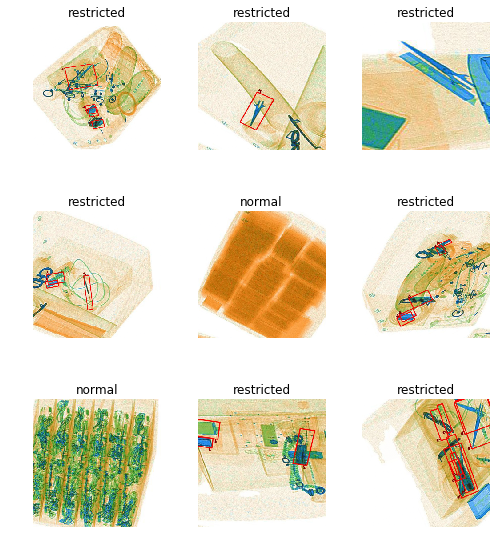

In [5]:
data.show_batch(rows=3, figsize=(7,8))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['normal', 'restricted'], 2, 5156, 1289)

In [7]:
learn = create_cnn(data, vgg16, metrics=accuracy, ps=0.5, bn_final=True)

In [8]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (5156 items)
x: ImageItemList
Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288)
y: CategoryList
normal,normal,normal,normal,normal
Path: data/train;

Valid: LabelList (1289 items)
x: ImageItemList
Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288),Image (3, 288, 288)
y: CategoryList
restricted,normal,restricted,restricted,normal
Path: data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, ker

In [9]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2, p

In [10]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy
1,0.501765,0.354393,0.961986
2,0.392489,0.248944,0.969744
3,0.307985,0.208563,0.975175
4,0.256309,0.206520,0.979829
5,0.238099,0.213093,0.975950


In [11]:
learn.unfreeze()

In [12]:
#learn.fit_one_cycle(20, max_lr=slice(3e-5,3e-4), callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='model')])

In [13]:
learn.fit_one_cycle(20, max_lr=slice(3e-5,3e-3), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])#1e-6,1e-3 (3e-5,3e-4)

epoch,train_loss,valid_loss,accuracy
1,0.229129,0.200462,0.981381
2,0.215820,0.176952,0.977502
3,0.195837,0.147561,0.986811
4,0.167154,0.112468,0.986811
5,0.136501,0.079450,0.987587
6,0.115014,0.058322,0.988363
7,0.088724,0.051639,0.988363
8,0.072887,0.041104,0.993018
9,0.056910,0.038706,0.993018
10,0.046869,0.029097,0.994569


Better model found at epoch 1 with accuracy value: 0.9813809394836426.
Better model found at epoch 3 with accuracy value: 0.9868114590644836.
Better model found at epoch 5 with accuracy value: 0.9875872731208801.
Better model found at epoch 6 with accuracy value: 0.9883630871772766.
Better model found at epoch 8 with accuracy value: 0.993017852306366.
Better model found at epoch 10 with accuracy value: 0.9945694208145142.
Better model found at epoch 12 with accuracy value: 0.9968968033790588.
Better model found at epoch 13 with accuracy value: 0.9976726174354553.


测试验证


In [14]:
interp = ClassificationInterpretation.from_learner(learn)

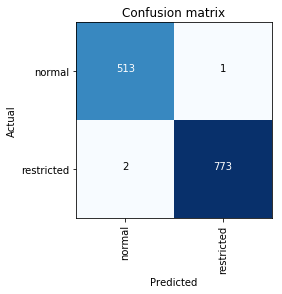

In [15]:
interp.plot_confusion_matrix()

In [16]:
#interp.most_confused()

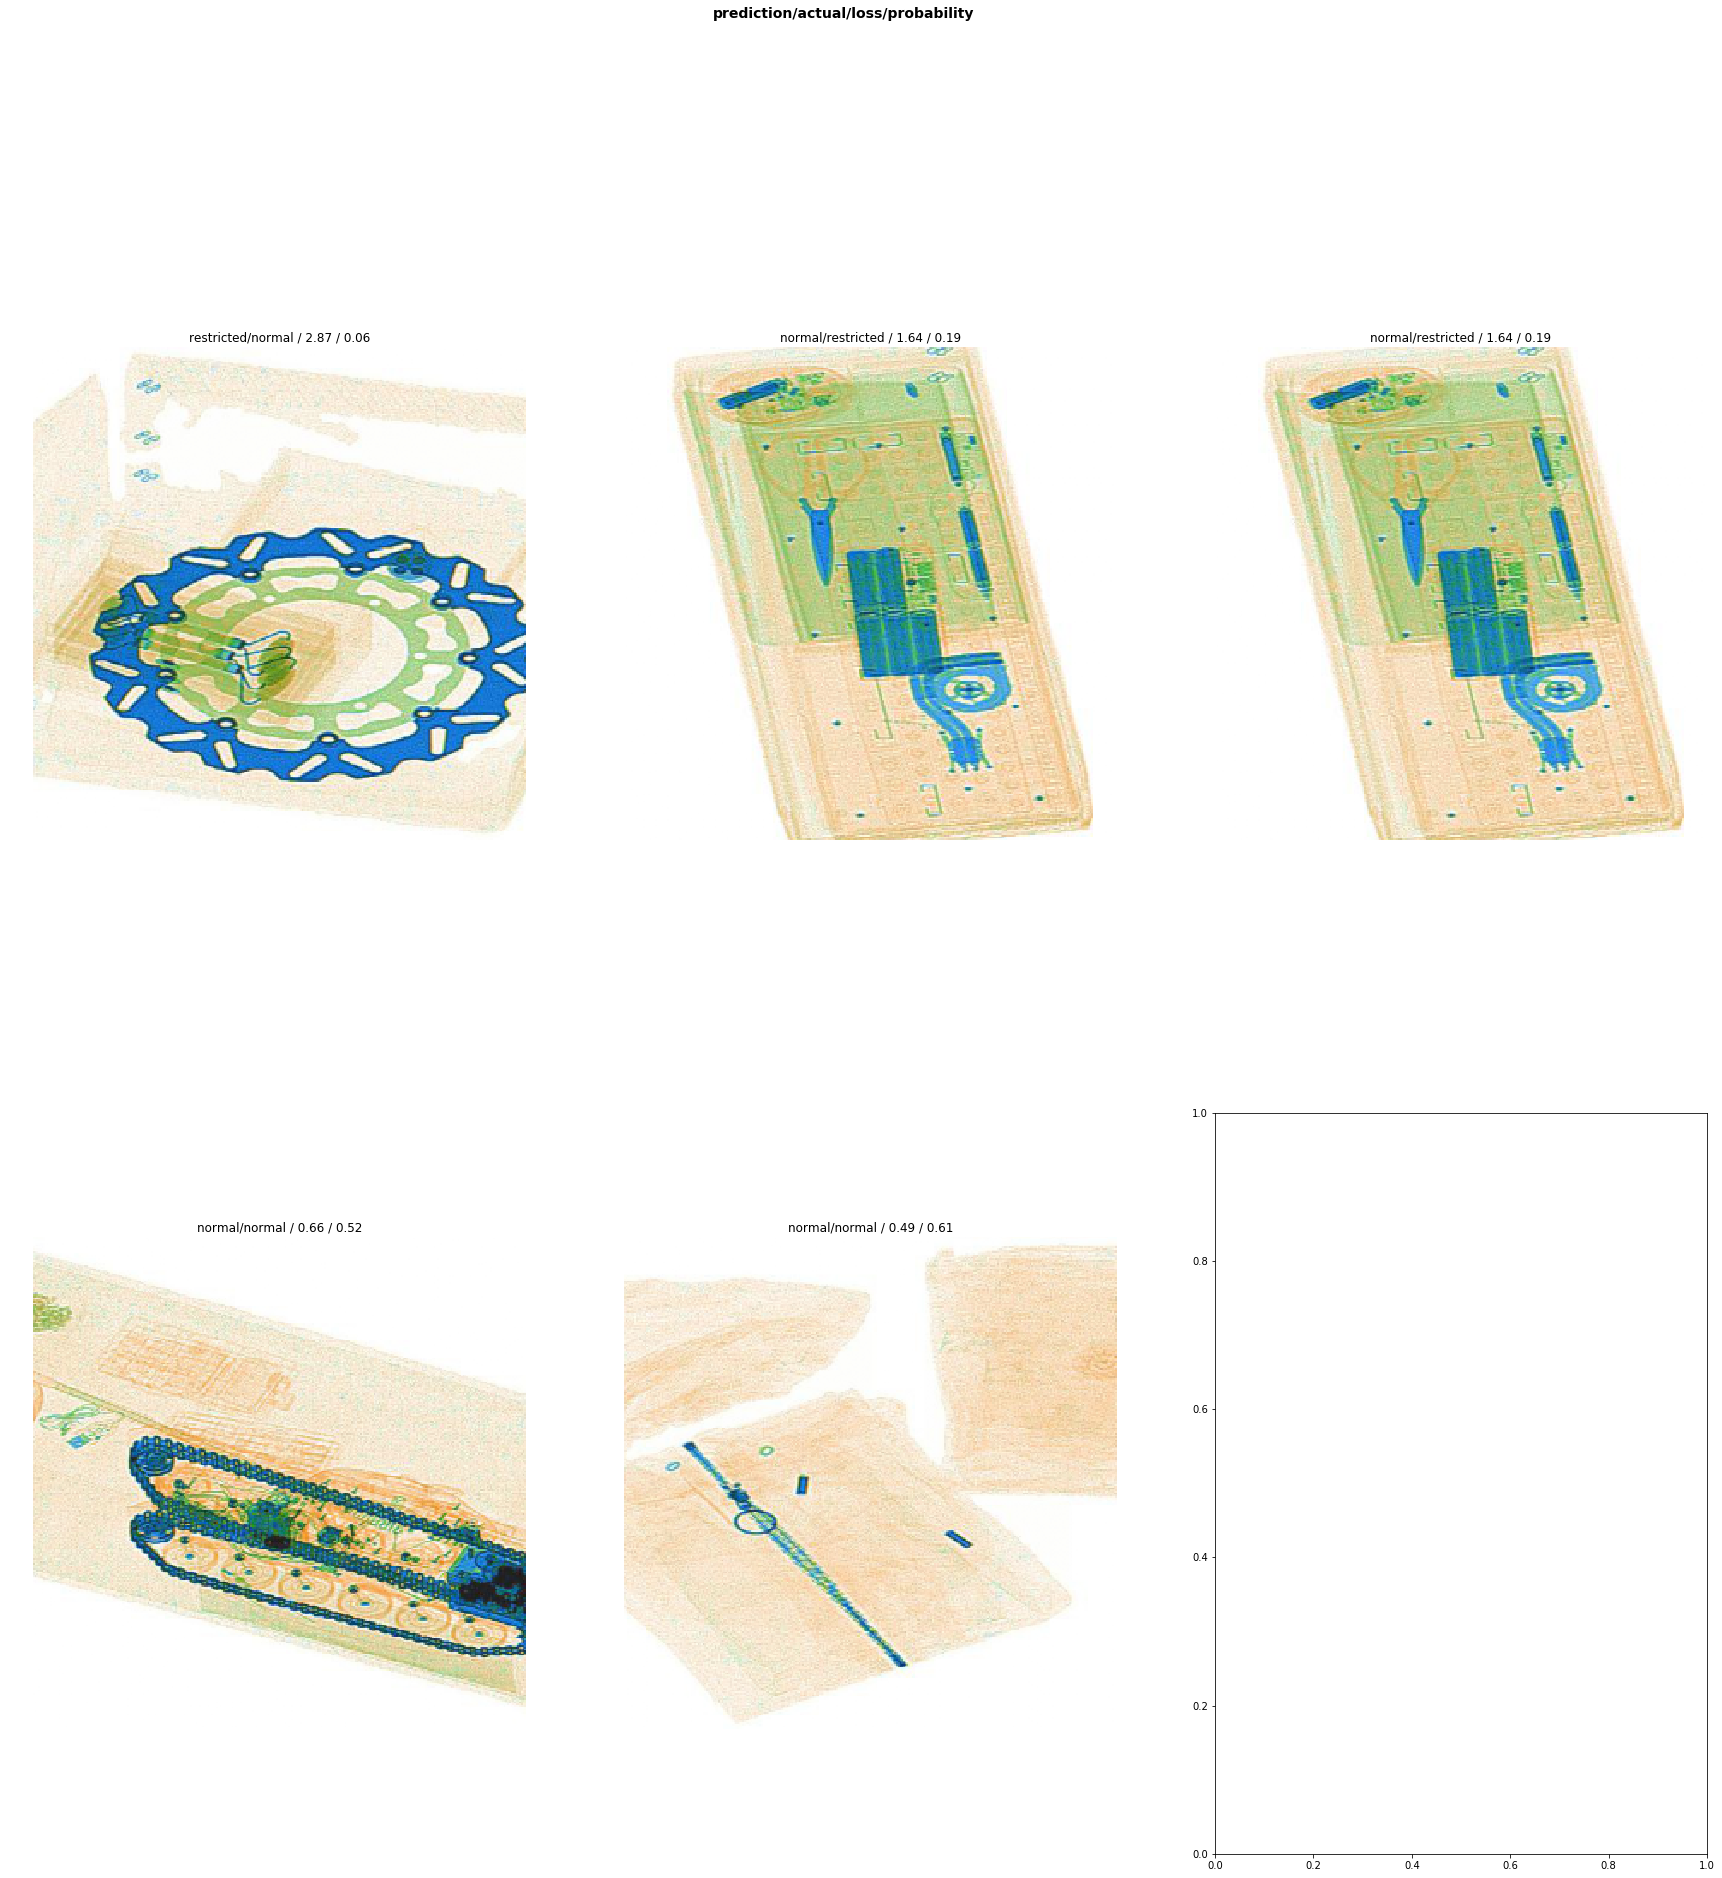

In [17]:
interp.plot_top_losses(5, figsize=(30,30))

In [18]:
learn.load('best');

In [19]:
learn.export('228_best_100.pkl')